<a href="https://colab.research.google.com/github/sujitpal/keras-tutorial-osdc2020/blob/master/03_02_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence to Sequence models

An important group of models built using the RNN network and its variants is the __sequence to sequence architecture__.

Sequence to sequence networks consist of an __encoder__ (shown in green) and a __decoder__ (shown in blue).

The encoder consumes the input sequence ("I", "like", "cats") and produces a representation of the sequence `C` also known as the "context vector".

The decoder will then use this context vector, the hidden state from the last encoder time step, and a SOS string as its input to produce the output "J'aime", then the context vector, the hidden state from the first decor time step, and it's output "J'aime" to produce the output "les", and so on until it finally produces the output sequence ("J'aime", "les", "chats").



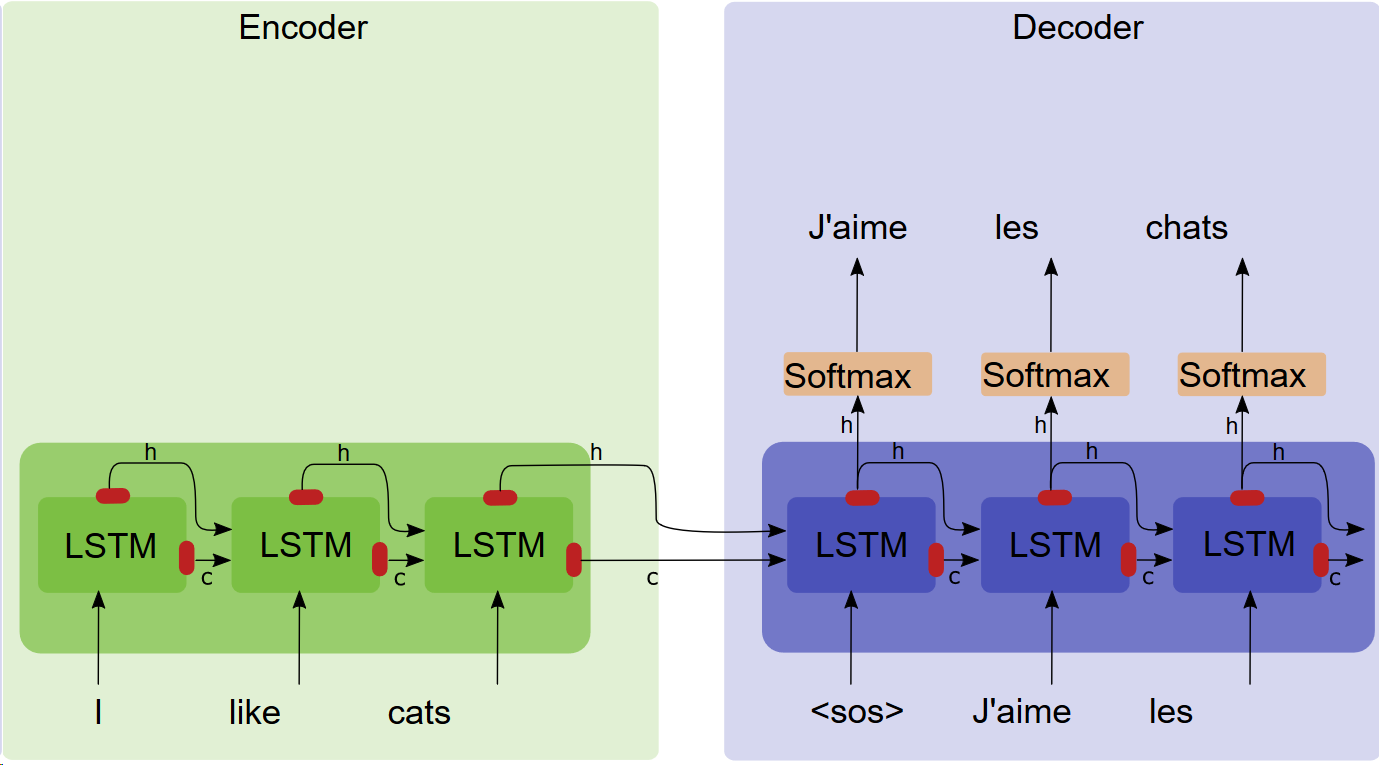

If the encoder sequence is long, then the encoder representation does not contain enough detail for the decoder to learn to generate the correct output.

That is where __attention__ comes in useful. Here, instead of just the context vector, the decoder has access to all the past states of the encoder. The decoder uses these past states to weigh the context vector at each of its output time steps.

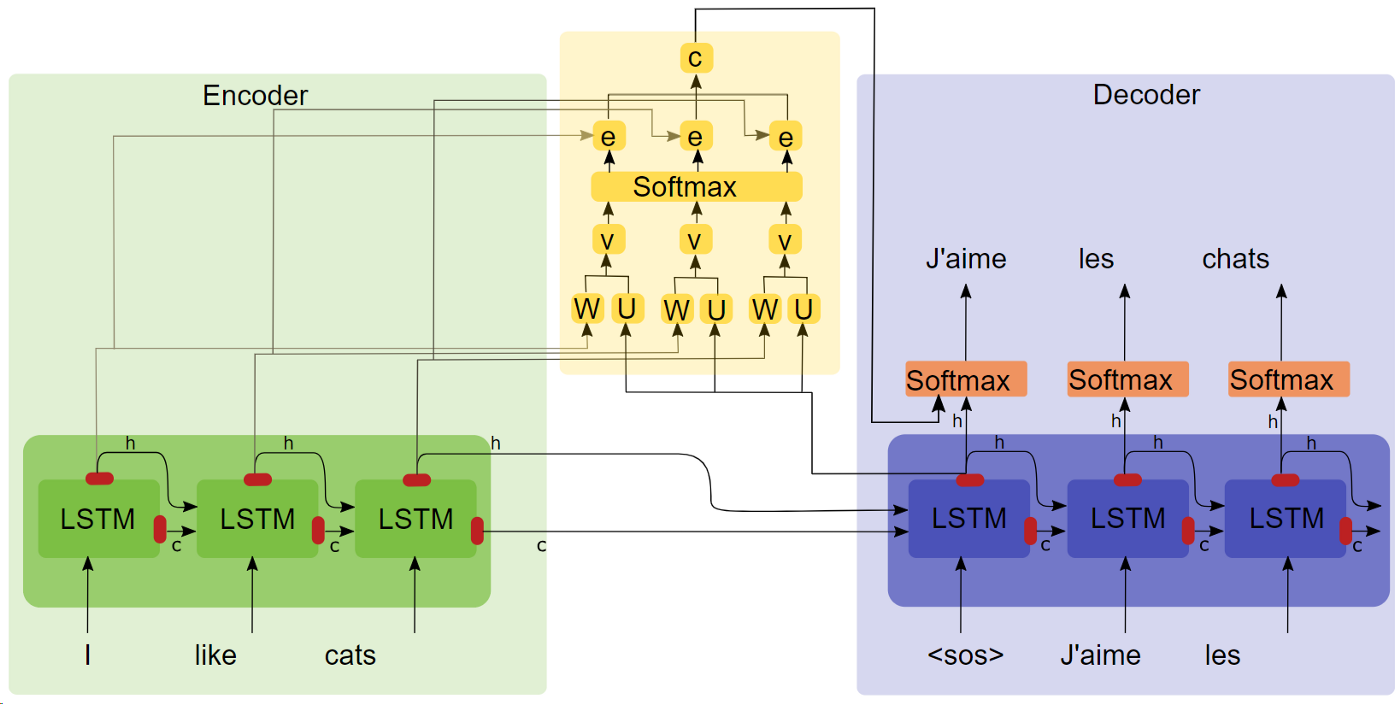

Images above are from [Attention in Deep Networks with Keras](https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39) by Thushan Ganegedara, who talks about his Attention layer implementation in Keras.

This notebook, we will demonstrate sequence to sequence networks for machine translation, with and without attention.

## Example 1: Sequence to Sequence

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

%matplotlib inline

## Data



In [2]:
%%bash
(
if [ ! -f fra.txt ]; then
  wget --quiet http://www.manythings.org/anki/fra-eng.zip
  unzip -a fra-eng.zip
  rm fra-eng.zip _about.txt
fi
)

In [3]:
num_pairs = 0
sents_en, sents_fr_in, sents_fr_out = [], [], []
with open("fra.txt", "r") as f:
  for line in f:
    if num_pairs % 50000 == 0:
      print("{:d} pairs read".format(num_pairs))
    cols = line.strip().split('\t')
    sent_en, sent_fr = cols[0], cols[1]
    sents_en.append([w for w in sent_en.split()])
    sents_fr_in.append([w for w in ("BOS " + sent_fr).split()])
    sents_fr_out.append([w for w in (sent_fr + " EOS").split()])
    num_pairs += 1

print("{:d} pairs read, COMPLETE".format(num_pairs))
print(len(sents_en), len(sents_fr_in), len(sents_fr_out))

0 pairs read
50000 pairs read
100000 pairs read
150000 pairs read
178009 pairs read, COMPLETE
178009 178009 178009


### Determine optimal sequence lengths

In [4]:
lens_en = [len(s) for s in sents_en]
lens_fr = [len(s) for s in sents_fr_in]

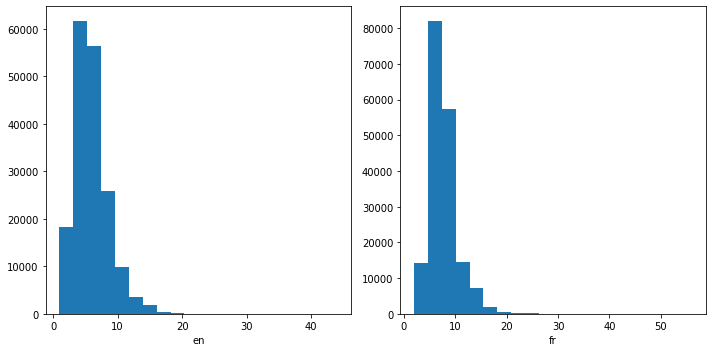

In [5]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(lens_en, bins=20)
plt.xlabel("en")

plt.subplot(1, 2, 2)
plt.hist(lens_fr, bins=20)
plt.xlabel("fr")

plt.tight_layout()
_ = plt.show()

In [6]:
print("en:", np.percentile(lens_en, [80, 90, 95, 99]))
print("fr:", np.percentile(lens_fr, [80, 90, 95, 99]))

en: [ 8.  9. 11. 14.]
fr: [10. 11. 13. 17.]


In [7]:
maxlen_en = 15
maxlen_fr = 20

### Determine optimum vocabulary size

The English and French vocabulary sizes created using the default `Tokenizer.fit_on_texts()` call are 26,229 and 43,104 respectively.

We will cut them down to 20,000 and 40,000 respectively.

In [8]:
vocab_size_en = 20000
vocab_size_fr = 40000

In [9]:
tokenizer_en = keras.preprocessing.text.Tokenizer(
    filters=" ", num_words=vocab_size_en, oov_token="__OOV__")
tokenizer_en.fit_on_texts(sents_en)
seqs_en = tokenizer_en.texts_to_sequences(sents_en)
seqs_en = keras.preprocessing.sequence.pad_sequences(
    seqs_en, maxlen=maxlen_en, padding="post")

tokenizer_fr = keras.preprocessing.text.Tokenizer(
    filters=" ", num_words=vocab_size_fr, oov_token = "__OOV__")
tokenizer_fr.fit_on_texts(sents_fr_in)
tokenizer_fr.fit_on_texts(sents_fr_out)
seqs_fr_in = tokenizer_fr.texts_to_sequences(sents_fr_in)
seqs_fr_in = keras.preprocessing.sequence.pad_sequences(
    seqs_fr_in, maxlen=maxlen_fr, padding="post")
seqs_fr_out = tokenizer_fr.texts_to_sequences(sents_fr_out)
seqs_fr_out = keras.preprocessing.sequence.pad_sequences(
    seqs_fr_out, maxlen=maxlen_fr, padding="post")

seqs_en.shape, seqs_fr_in.shape, seqs_fr_out.shape

((178009, 15), (178009, 20), (178009, 20))

In [10]:
word_index = tokenizer_en.word_index
word_index["__PAD__"] = 0
word2idx_en = {k:v for k, v in word_index.items() if v < vocab_size_en}
idx2word_en = {v:k for k, v in word2idx_en.items()}

word_index = tokenizer_fr.word_index
word_index["__PAD__"] = 0
word2idx_fr = {k:v for k, v in word_index.items() if v < vocab_size_fr}
idx2word_fr = {v:k for k, v in word2idx_fr.items()}

len(word2idx_en), len(word2idx_fr)

(20000, 40000)

### Split Data into training and test

In [11]:
from sklearn.model_selection import train_test_split

seqs_en_train, seqs_en_test, seqs_fr_in_train, seqs_fr_in_test, seqs_fr_out_train, seqs_fr_out_test = \
  train_test_split(seqs_en, seqs_fr_in, seqs_fr_out, test_size=0.2, random_state=1)
print("train:", seqs_en_train.shape, seqs_fr_in_train.shape, seqs_fr_out_train.shape)
print("test :", seqs_en_test.shape, seqs_fr_in_test.shape, seqs_fr_out_test.shape)

train: (142407, 15) (142407, 20) (142407, 20)
test : (35602, 15) (35602, 20) (35602, 20)


## Example 1: seq2seq without attention

In [12]:
# encoder
encoder_input = keras.layers.Input(shape=(maxlen_en,), dtype="int32")
encoder_embed = keras.layers.Embedding(vocab_size_en, 300, mask_zero=True)(encoder_input)
encoder_context = keras.layers.GRU(64, return_sequences=False)(encoder_embed)

# decoder
decoder_input = keras.layers.Input(shape=(maxlen_fr,), dtype="int32")
decoder_embed = keras.layers.Embedding(vocab_size_fr, 300, mask_zero=True)(decoder_input)

decoder_rnn = keras.layers.GRU(64, return_sequences=True, return_state=True)
decoder_output, _ = decoder_rnn(decoder_embed, initial_state=encoder_context)
output = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size_fr, activation="softmax"))(decoder_output)

# model
model_1 = keras.models.Model(inputs=[encoder_input, decoder_input], outputs=output)
model_1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 300)      6000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 300)      12000000    input_2[0][0]                    
_______________________________________________________________________________________

In [13]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss")
model_checkpoint = keras.callbacks.ModelCheckpoint("/tmp/model_1", 
                                                   monitor="val_loss", 
                                                   save_best_only=True)
history_1 = model_1.fit(x=[seqs_en_train, seqs_fr_in_train], y=seqs_fr_out_train, 
                        batch_size=128, epochs=5,
                        validation_split=0.2,
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
891/891 [==============================] - ETA: 0s - loss: 2.2955 - accuracy: 0.1943WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/model_1/assets
891/891 [==============================] - 279s 313ms/step - loss: 2.2955 - accuracy: 0.1943 - val_loss: 1.9492 - val_accuracy: 0.2737
Epoch 2/5
891/891 [==============================] - 276s 310ms/step - loss: 1.7592 - accuracy: 0.3226 - val_loss: 1.6444 - val_accuracy: 0.3568
Epoch 3/5
891/891 [==============================] - 276s 310ms/step - loss: 1.5120 - accuracy: 0.3

In [15]:
# model_1s = keras.models.load_model("/tmp/model_1")
scores_1 = model_1.evaluate(x=[seqs_en_test, seqs_fr_in_test], 
                            y=seqs_fr_out_test)
print("test loss: {:.5f}, accuracy: {:.5f}".format(scores_1[0], scores_1[1]))

1113/1113 [==============================] - 51s 46ms/step - loss: 1.2967 - accuracy: 0.4426
test loss: 1.29667, accuracy: 0.44257


## Example 2: seq2seq with attention

The major changes from the seq2seq without attention network are as follows:

* the `encoder_rnn` has `return_sequences=True`, which gives us `encoder_output` of shape `[None, maxlen_en, 64]`, one for each input time step.
* we compute attention over the `decoder_output` and `encoder_output`, and use that as an additional input to the `Dense` layers with the `decoder_output`.

In [16]:
# encoder
encoder_input = keras.layers.Input(shape=(maxlen_en,), dtype="int32")
encoder_embed = keras.layers.Embedding(vocab_size_en, 300, mask_zero=True)(encoder_input)

encoder_rnn = keras.layers.GRU(64, return_sequences=True, return_state=True)
encoder_output, encoder_state = encoder_rnn(encoder_embed)

# decoder
decoder_input = keras.layers.Input(shape=(maxlen_fr,), dtype="int32")
decoder_embed = keras.layers.Embedding(vocab_size_fr, 300, mask_zero=True)(decoder_input)

decoder_rnn = keras.layers.GRU(64, return_sequences=True)
decoder_output = decoder_rnn(decoder_embed, initial_state=encoder_state)

# attention
attended_output = keras.layers.Attention()([decoder_output, encoder_output])
combined_output = keras.layers.Add()([attended_output, decoder_output])

output = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size_fr, activation="softmax"))(combined_output)

# model
model_2 = keras.models.Model(inputs=[encoder_input, decoder_input], outputs=output)
model_2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 15, 300)      6000000     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 20, 300)      12000000    input_4[0][0]                    
_______________________________________________________________________________________

In [17]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss")
model_checkpoint = keras.callbacks.ModelCheckpoint("/tmp/model_2", 
                                                   monitor="val_loss", 
                                                   save_best_only=True)
history_2 = model_2.fit(x=[seqs_en_train, seqs_fr_in_train], y=seqs_fr_out_train, 
                        batch_size=128, epochs=5,
                        validation_split=0.2,
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
891/891 [==============================] - 271s 304ms/step - loss: 2.2278 - accuracy: 0.2069 - val_loss: 1.8271 - val_accuracy: 0.3027
Epoch 2/5
891/891 [==============================] - 271s 304ms/step - loss: 1.6222 - accuracy: 0.3562 - val_loss: 1.4961 - val_accuracy: 0.3992
Epoch 3/5
891/891 [==============================] - 271s 304ms/step - loss: 1.3390 - accuracy: 0.4386 - val_loss: 1.3148 - val_accuracy: 0.4556
Epoch 4/5
891/891 [==============================] - 270s 303ms/step - loss: 1.1534 - accuracy: 0.4940 - val_loss: 1.2039 - val_accuracy: 0.4920
Epoch 5/5
891/891 [==============================] - 270s 303ms/step - loss: 1.0177 - accuracy: 0.5365 - val_loss: 1.1260 - val_accuracy: 0.5176


In [18]:
# model_2s = keras.models.load_model("/tmp/model_2")
scores_2 = model_2.evaluate(x=[seqs_en_test, seqs_fr_in_test], 
                            y=seqs_fr_out_test)
print("test loss: {:.5f}, accuracy: {:.5f}".format(scores_2[0], scores_2[1]))

1113/1113 [==============================] - 51s 46ms/step - loss: 1.1297 - accuracy: 0.5163
test loss: 1.12974, accuracy: 0.51630
